# Bootstrap particle filter

Notebook about testing the implementation of bootstrap particle filter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [2]:
from src.models.mssv import MSSVModelParams, MSSVModel
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

In [57]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# True parameters
theta = MSSVModelParams(
    mu=[-1.0, 1.6],
    phi=[0.95, 0.95],
    sigma_eta=[0.1, 0.2],
    P=[[0.95, 0.05],
        [0.05, 0.95]]
)

# Initialize model
model = MSSVModel(rng=rng)

In [81]:
# Simulate data
T = 300
true_states, y = simulate_data(model, theta, T, rng)

In [59]:
print(y.shape)  # (T,)

(300, 1)


In [60]:
# Run particle filter
pf = BootstrapParticleFilter(model, n_particles=1000, resampler=systematic_resampling)
history = pf.run(y, theta)

In [61]:
h_true = np.array([state.h_t for state in true_states])
s_true = np.array([np.argmax(state.s_t) for state in true_states])

T = len(history) - 1  # -1 because history includes initial step t=0
N = len(history[0][1])
K = len(theta.mu)  # number of regimes

print("Number of time steps:", T)
print("Number of particles:", N)
print("Number of regimes:", K)

Number of time steps: 300
Number of particles: 1000
Number of regimes: 2


In [62]:
from scipy.stats import gaussian_kde

def HDI(values, weights, cred_mass=0.95, gridsize=1000):
    values = np.array(values)
    weights = np.array(weights)
    assert np.isclose(weights.sum(), 1.0)

    # ----- KDE -----
    kde = gaussian_kde(values, weights=weights)
    x_grid = np.linspace(values.min() - 0.2 * (values.max() - values.min()), values.max() + 0.2 * (values.max() - values.min()), gridsize)
    pdf = kde(x_grid)
    pdf /= pdf.sum() * (x_grid[1]-x_grid[0])  # normalize to integrate to 1

    # ----- Determine threshold for HDI -----
    # Sort densities descending
    idx_sort = np.argsort(pdf)[::-1]
    pdf_sorted = pdf[idx_sort]

    cum_prob = 0.0
    included = np.zeros_like(x_grid, dtype=bool)
    threshold = 0.0
    for i, p in enumerate(pdf_sorted):
        # find original index in x_grid
        orig_idx = idx_sort[i]
        included[orig_idx] = True
        cum_prob += p * (x_grid[1]-x_grid[0])
        if cum_prob >= cred_mass:
            threshold = p
            break

    # Calculate intersections of pdf with threshold to find HDI intervals
    above_threshold = pdf >= threshold
    intervals = []
    in_interval = False
    for i in range(1, len(above_threshold)):
        if above_threshold[i] and not above_threshold[i-1]:
            # Start of interval
            start = x_grid[i]
            in_interval = True
        elif not above_threshold[i] and above_threshold[i-1] and in_interval:
            # End of interval
            end = x_grid[i-1]
            intervals.append((start, end))
            in_interval = False
    if in_interval:
        intervals.append((start, x_grid[-1]))
    HDI_intervals = intervals

    return HDI_intervals

def mean_median(values, weights):
    values = np.array(values)
    weights = np.array(weights)
    assert np.isclose(weights.sum(), 1.0)

    # Weighted mean & median
    mean = np.sum(values * weights)
    sorted_idx = np.argsort(values)
    cum_weights = np.cumsum(weights[sorted_idx])
    median = values[sorted_idx][np.searchsorted(cum_weights, 0.5)]

    return mean, median

In [63]:
# Extract particles and weights as arrays
h_array = np.array([ history[t][0].h_t for t in range(0, T+1) ])  # shape (T+1, N)
s_array = np.array([np.argmax(history[t][0].s_t, axis=1) for t in range(0, T+1)])  # shape (T+1, N)
weights_array = np.array([ history[t][1] for t in range(0, T+1) ])                 # shape (T+1, N)

print("Extracted arrays shapes:")
print("h_array:", h_array.shape)
print("s_array:", s_array.shape)
print("weights_array:", weights_array.shape)

Extracted arrays shapes:
h_array: (301, 1000)
s_array: (301, 1000)
weights_array: (301, 1000)


In [64]:
h_mean_all = []
h_median_all = []
h_HDI_all = []

s_median_all = []

for t in range(T+1):
    h_t = h_array[t]
    weights_t = weights_array[t]
    HDI_intervals = HDI(h_t, weights_t, cred_mass=0.95)
    mean, median = mean_median(h_t, weights_t)
    h_mean_all.append(mean)
    h_median_all.append(median)
    h_HDI_all.append(HDI_intervals)

    s_t = s_array[t]
    mean, median = mean_median(s_t, weights_t)
    s_median_all.append(median)

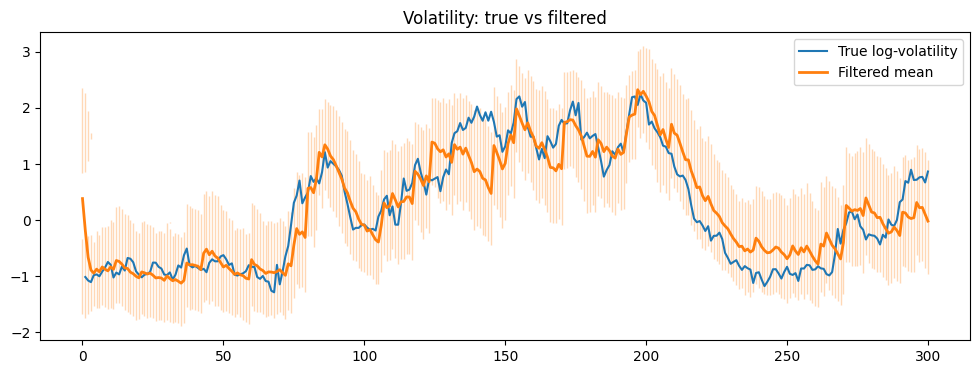

In [88]:
# Plot graph of true vs estimated log volatility
plt.figure(figsize=(12, 4))
plt.plot(np.arange(1, T+1), h_true, label="True log-volatility")
plt.plot(np.arange(0, T+1), h_mean_all, label="Filtered mean", linewidth=2)

# Loop over each time point and fill all intervals
for t in range(T+1):
    intervals = h_HDI_all[t]  # This should be a list of [low, high] pairs
    for low, high in intervals:
        plt.fill_between([t, t], [low, low], [high, high], color='C1', alpha=0.3)

plt.legend()
plt.title("Volatility: true vs filtered")
plt.show()

In [66]:
# Print last mean and HDI
print("Last time step log-volatility estimates:")
print("Mean:", h_mean_all[-1])
print("95% HDI intervals:", h_HDI_all[-1])

Last time step log-volatility estimates:
Mean: -0.01864779327926045
95% HDI intervals: [(np.float64(-0.9644672784939147), np.float64(1.0719833004852437))]


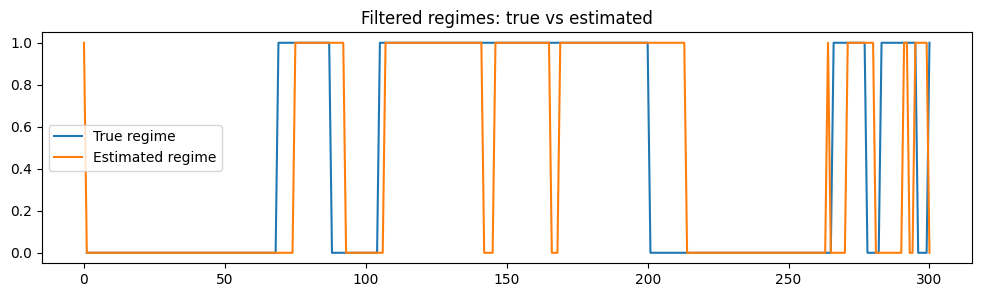

In [67]:
# Plot graph of true vs estimated regimes
plt.figure(figsize=(12, 3))
plt.plot(np.arange(1, T+1), s_true, label="True regime")
plt.plot(np.arange(0, T+1), s_median_all, label="Estimated regime")
plt.legend()
plt.title("Filtered regimes: true vs estimated")
plt.show()

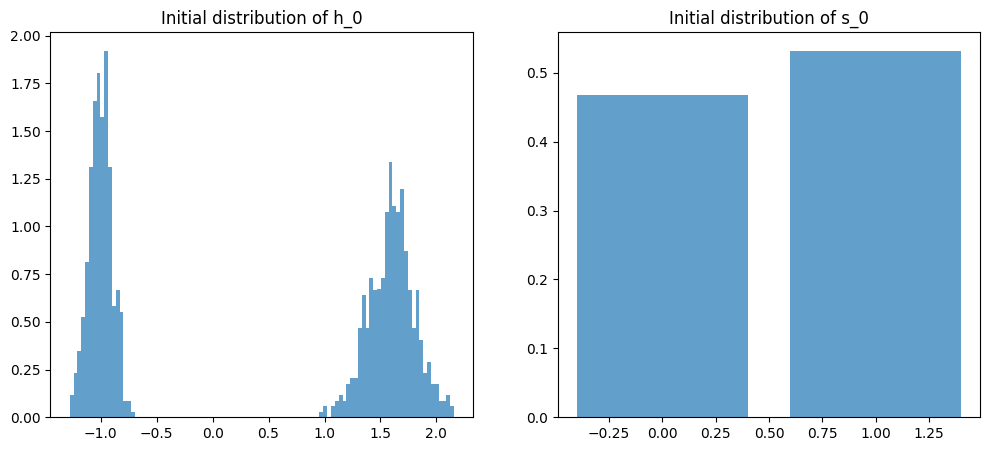

In [68]:
# Plot initial distribution p(x_0) (the prior)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(h_array[0], bins=100, density=True, alpha=0.7)
plt.title("Initial distribution of h_0")
plt.subplot(1, 2, 2)
plt.hist(s_array[0], bins=np.arange(-0.5, K+0.5, 1), density=True, alpha=0.7, rwidth=0.8)
plt.title("Initial distribution of s_0")
plt.show()


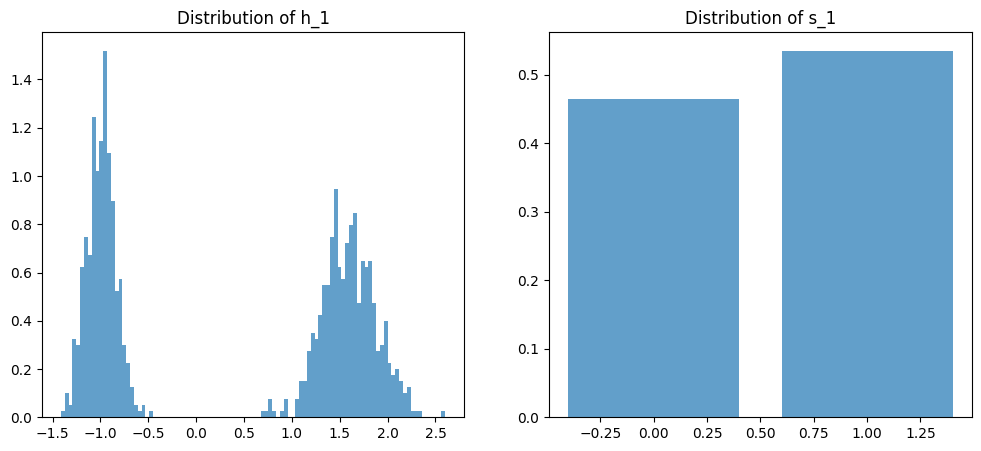

In [69]:
# At t=0 we have no data yet, so we just propagate the particles
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(h_array[1], bins=100, density=True, alpha=0.7)
plt.title("Distribution of h_1")
plt.subplot(1, 2, 2)
plt.hist(s_array[1], bins=np.arange(-0.5, K+0.5, 1), density=True, alpha=0.7, rwidth=0.8)
plt.title("Distribution of s_1")
plt.show()

In [70]:
# Let's look at the data at t=1
print("Initial data (t=1):")
print("y:", y[0])
print("true_states:", true_states[0].h_t, np.argmax(true_states[0].s_t))

Initial data (t=1):
y: [0.55382761]
true_states: [-1.01554229] 0


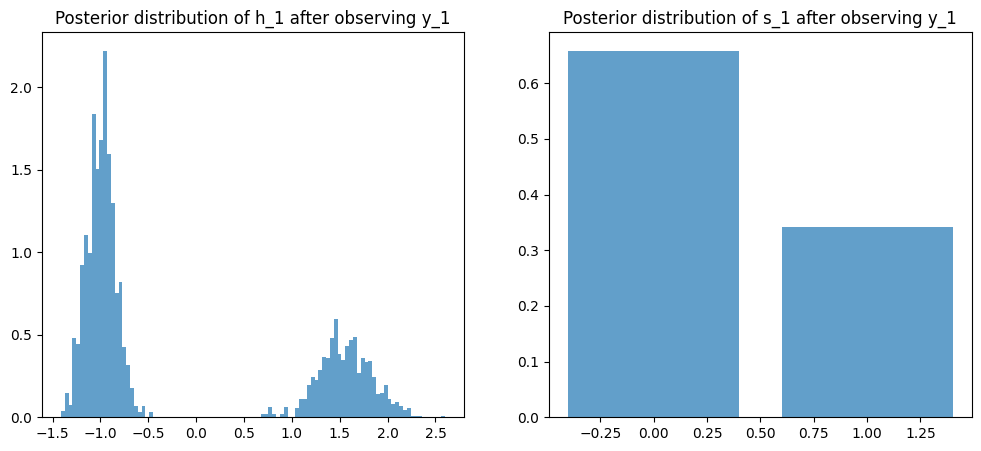

In [71]:
# Now let's see how our belief is updated after observing the first data point y[0]
# So we are looking at the distribution p(x_1 | y_1)
h_1_particles = h_array[1]
s_1_particles = s_array[1]
weights_1 = weights_array[1]

# Plot weighted histogram of h_1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(h_1_particles, bins=100, weights=weights_1, density=True, alpha=0.7)
plt.title("Posterior distribution of h_1 after observing y_1")
plt.subplot(1, 2, 2)
plt.hist(s_1_particles, bins=np.arange(-0.5, K+0.5, 1), weights=weights_1, density=True, alpha=0.7, rwidth=0.8)
plt.title("Posterior distribution of s_1 after observing y_1")
plt.show()

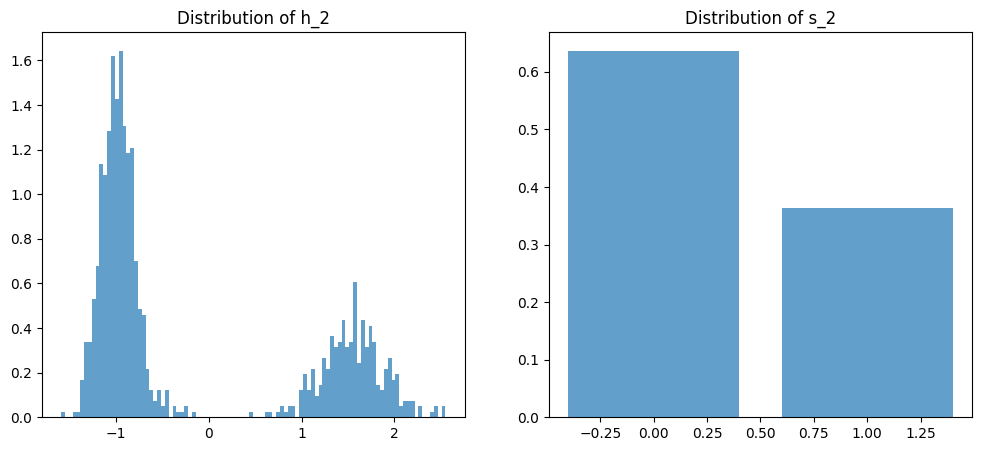

In [72]:
# Now let's propagate the particles to the next time step t=2
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(h_array[2], bins=100, density=True, alpha=0.7)
plt.title("Distribution of h_2")
plt.subplot(1, 2, 2)
plt.hist(s_array[2], bins=np.arange(-0.5, K+0.5, 1), density=True, alpha=0.7, rwidth=0.8)
plt.title("Distribution of s_2")
plt.show()

In [73]:
# Let's look at data at t=2
print("Data at t=2:")
print("y:", y[1])
print("true_states:", true_states[1].h_t, np.argmax(true_states[1].s_t))

Data at t=2:
y: [0.31607264]
true_states: [-1.07841154] 0


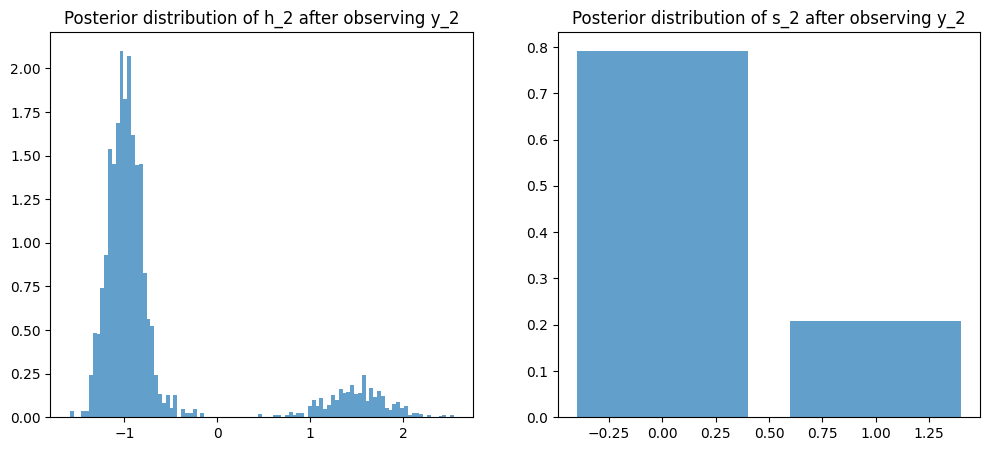

In [74]:
# Repeat how our belief is updated after observing the second data point y[1]
# So we are looking at the distribution p(x_2 | y_2)
h_2_particles = h_array[2]
s_2_particles = s_array[2]
weights_2 = weights_array[2]
# Plot weighted histogram of h_2
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(h_2_particles, bins=100, weights=weights_2, density=True, alpha=0.7)
plt.title("Posterior distribution of h_2 after observing y_2")
plt.subplot(1, 2, 2)
plt.hist(s_2_particles, bins=np.arange(-0.5, K+0.5, 1), weights=weights_2, density=True, alpha=0.7, rwidth=0.8)
plt.title("Posterior distribution of s_2 after observing y_2")
plt.show()


In [75]:
from src.filters.smc.smoothing import get_smoothing_trajectories

In [76]:
# Now let's perform smoothing to get smoothed state estimates p(x_1:T | y_1:T)
smoothed_trajectories = get_smoothing_trajectories(history)

In [82]:
n_traj = len(smoothed_trajectories)   # number of trajectories

# Initialize arrays
h_array = np.zeros((n_traj, T+1))                   # for h_t, +1 to include t=0
s_array = np.zeros((n_traj, T+1, K), dtype=int)     # for s_t if discrete

# Fill arrays
for i, traj in enumerate(smoothed_trajectories):
    for t in range(T+1):
        h_array[i, t] = traj[t].h_t      # MSSV latent
        s_array[i, t] = traj[t].s_t      # MSSV discrete state


In [83]:
# Final weights from history are not needed for smoothing trajectories
weights_T = np.array(history[T][1])  # shape (N,)
print(weights_T.shape)
print(T)

(1000,)
300


In [84]:
h_mean = np.sum(h_array * weights_T[:, None], axis=0)

regime_probs = np.sum(s_array * weights_T[:, None, None], axis=0) # shape (T, K)
# Extract most probable regime at each time step
s_mode = np.argmax(regime_probs, axis=1)  # shape (T)

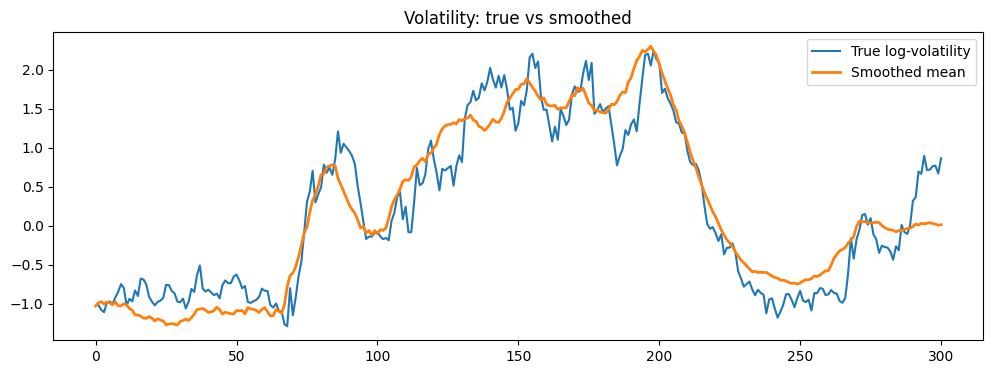

In [86]:
# Plot the graph of true vs smoothed log volatility
plt.figure(figsize=(12, 4))
plt.plot(np.arange(1, T+1), h_true, label="True log-volatility")
plt.plot(np.arange(0, T+1), h_mean, label="Smoothed mean", linewidth=2)
plt.legend()
plt.title("Volatility: true vs smoothed")
plt.show()

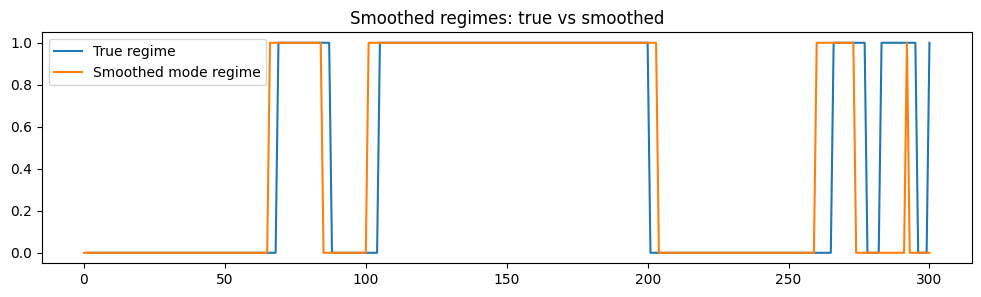

In [87]:
# Plot graph of true vs smoothed regimes
plt.figure(figsize=(12, 3))
plt.plot(np.arange(1, T+1), s_true, label="True regime")
plt.plot(np.arange(0, T+1), s_mode, label="Smoothed mode regime")
plt.legend()
plt.title("Smoothed regimes: true vs smoothed")
plt.show()